In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import random as rd
import time

sys.path.append("..")

from AllMethods import ReversibleSymplecticNN as rs
from AllMethods import PerturbedPendulum_Methods as pp

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.1)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

## Load dataset

In [8]:
x, y = pp.read_dataset('x_train.txt', 'y_train.txt')
train_dataset, val_dataset = pp.train_dataset(x[:100], y[:100], 10, 90, 10) #val_len, train_batch, val_batch

## Define the model as in https://arxiv.org/abs/2001.03750:

### The first argument is the number of activation modules, the second argument is the number of liear modules between each activation. The third argument can be either 'reversible' or 'non-reversible' to generate a model that is either a time-reversible composition of linear and activation modules or a random composition (as in the original paper) of linear and activatin modules respectively.

In [9]:
model1N2 = rs.SympNet(18, 5, 'non_reversible')

## Callback function for decaying learning rate

In [10]:
def scheduler(epoch, lr):
    if epoch%100==0:
        print("epoch: ", epoch)
    if epoch < 5:
        return lr
    else:
        return lr*tf.math.exp(-0.0006)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Checkpoints

In [11]:
checkpoint_path_1N2 = "checkpoints_SN_PP_1N2_008/cp.ckpt"
checkpoint_dir_1N2 = os.path.dirname(checkpoint_path_1N2)

cp_callback_1N2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_1N2,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=0)

## Training

In [12]:
model1N2.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=["accuracy"],
)

Epochs = 3000
t = time.time()
history1N2 = model1N2.fit(train_dataset, epochs = Epochs, validation_data=val_dataset, callbacks=[callback, cp_callback_1N2], verbose=0)
print("Training time:" + str(time.time()-t))

epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
Training time:379.6046290397644


## Load best model

In [13]:
model1N2.load_weights(checkpoint_path_1N2)

## Plot the loss and save it as a .txt file

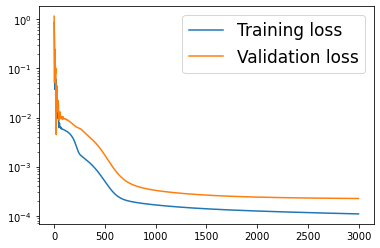

In [14]:
os. remove("PP_SN_Loss.txt")
f = open("PP_SN_Loss.txt", "a")
for i in history1N2.history["loss"]:
        f.write(str(i))
        f.write("\n")
f.close()

os.remove("PP_SN_Val.txt")
f = open("PP_SN_Val.txt", "a")
for i in history1N2.history["val_loss"]:
        f.write(str(i))
        f.write("\n")
f.close()

plt.plot(history1N2.history["loss"], label="Training loss")
plt.plot(history1N2.history["val_loss"], label="Validation loss")
plt.yscale("log")
plt.legend(fontsize=17)
plt.show()

## Poincare plot

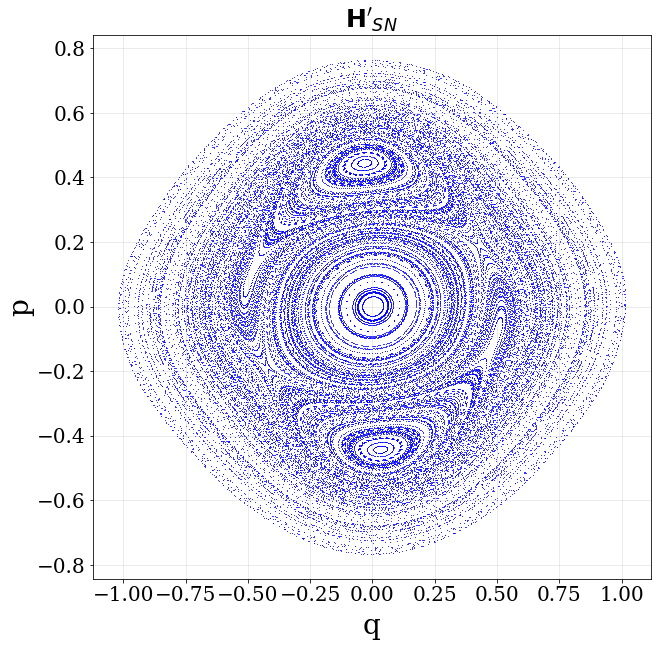

In [15]:
N = 300
x0 = np.array([[rd.randrange(-600, 600, 1)*0.001, rd.randrange(-600, 600, 1)*0.001] for _ in range(N)])
iterations = [model1N2(x0)]
for _ in range(200):
    iterations.append(model1N2(iterations[-1]))
    
plt.figure(figsize=(10,10))
plt.rc('font', family='serif')
plt.title("$\mathbf{H}'_{SN}$", fontsize = 25)

colors = []
sizes = []
for i in range(N):
    if i==18:
        colors.append("r")
        sizes.append(10)
    else:
        colors.append("b")
        sizes.append(1)

plt.scatter(*zip(*iterations[0].numpy()), s=1, linewidth=0, color="b", label = "Iterations")

for i in iterations:
    plt.scatter(*zip(*i.numpy()), s=1, linewidth=0, color="b")
    
#plt.scatter(*zip(*x0), s=10, linewidth=0, color="r", label = "Starting points")


plt.xlabel("q", fontsize=28, labelpad=8)
plt.ylabel("p", fontsize=28, labelpad=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
#lgnd = plt.legend(loc="upper right", numpoints=1, fontsize=20)
#lgnd.legendHandles[0]._sizes = [15]
#lgnd.legendHandles[1]._sizes = [30]
plt.savefig("Test_PP_SN")
plt.show()

## Future state prediction

In [16]:
from scipy.integrate import odeint
from scipy.misc import derivative

## Hamiltonian system for numerical integration

In [17]:
def pend(y, t):
     q, p  = y
     dydt = [- p + 0.5*(0.3*q*np.sin(2*t) + 0.7*q*np.sin(3*t)), 0.25*np.sin(q) - 0.5*(0.3*p*np.sin(2*t) + 0.7*p*np.sin(3*t))]
     return dydt


def Tau(y0):
    sol = odeint(pend, y0, np.linspace(0, 2*np.pi, 1000))
    return sol[-1]

## Starting points

In [18]:
N_predictions = 100
x0 = np.array([[0.0, 0.1],[0.0, 0.2],[0.0, 0.3],[0.0, 0.4],[0.0, 0.5],[0.0, 0.6],[0.1, 0.],[0.2, 0.],[0.3, 0.],[0.4, 0.],[0.5, 0.]])

## Numerical integration

In [19]:
Tu = []
for u in x0:
    a = Tau(u)
    Tu.append(a)
    for i in range(100):
        a = Tau(a)
        Tu.append(a)

## Using the trained evolution map

In [21]:
iterations = [model1N2(x0)]
for _ in range(N_predictions):
    iterations.append(model1N2(iterations[-1]))

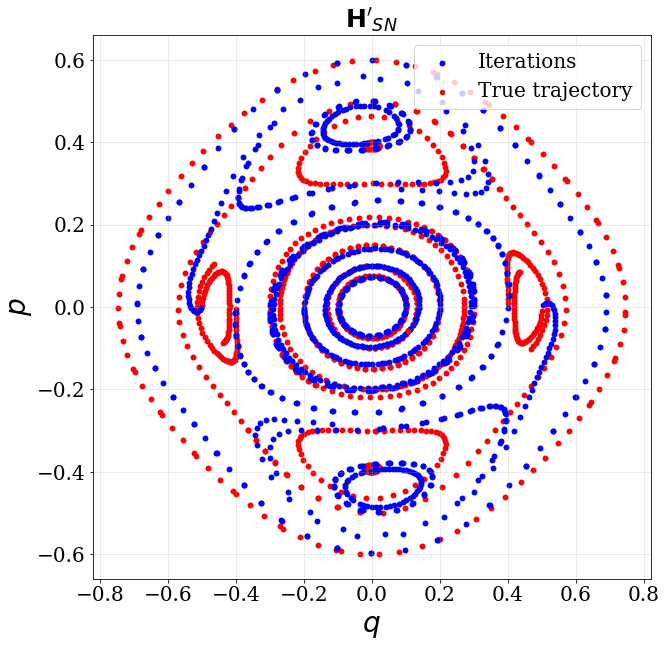

In [22]:
plt.figure(figsize=(10,10))
plt.rc('font', family='serif')
plt.title("$\mathbf{H}'_{SN}$", fontsize = 25)
    
for i in Tu:
    plt.scatter(i[0], i[1], s=35, linewidth=0, color="r")


plt.scatter(*zip(*iterations[0].numpy()), s=35, linewidth=0, color="b", label = "Iterations")

for i in iterations:
    plt.scatter(*zip(*i.numpy()), s=35, linewidth=0, color="b")


plt.scatter(i[0][0], i[0][1], s=35, linewidth=0, color="r", label="True trajectory")
    
#plt.scatter(*zip(*x0), s=20, linewidth=0, color="r", label = "Starting points")

plt.xlabel(r'$q$', fontsize=28, labelpad=8)
plt.ylabel(r'$p$', fontsize=28, labelpad=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
lgnd = plt.legend(loc="upper right", numpoints=1, fontsize=20)
lgnd.legendHandles[0]._sizes = [35]
lgnd.legendHandles[1]._sizes = [30]
plt.savefig("Iteration_Test_PP_SN")
plt.show()

## Errors

In [18]:
errors = []
for u in x0:
    error = []
    Taus = [u]
    models = [[u]]
    for _ in range(30):
        error.append(tf.norm(Tau(Taus[-1]) - model1N2(models[-1])[0]).numpy())
        Taus.append(Tau(Taus[-1]))
        models.append(model1N2(models[-1]))
    errors.append(error)

In [19]:
avg_error = []
for i in range(30):
    avg = 0
    for p in errors:
        avg = avg + p[i]
    avg_error.append(avg/len(errors))

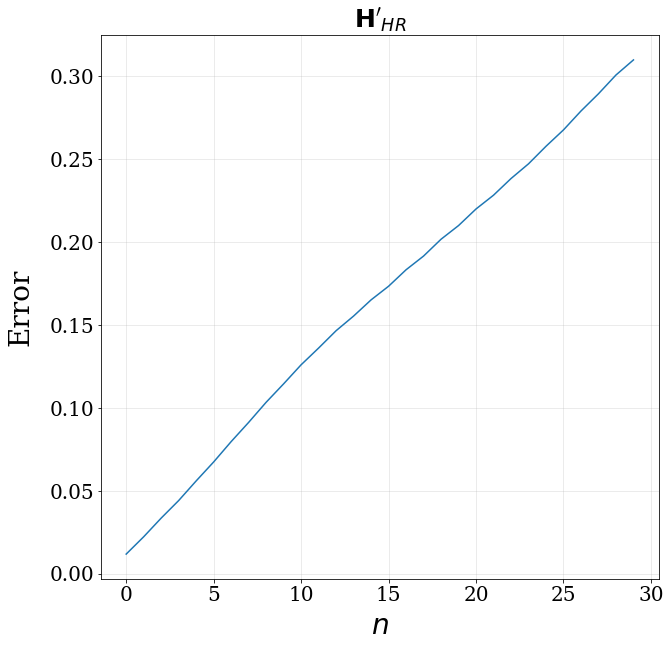

In [20]:
plt.figure(figsize=(10,10))
plt.rc('font', family='serif')
plt.title("$\mathbf{H}'_{HR}$", fontsize = 25)

plt.plot(avg_error)

plt.xlabel(r'$n$', fontsize=28, labelpad=8)
plt.ylabel(r'Error', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
#lgnd = plt.legend(loc="upper right", numpoints=1, fontsize=20)
#lgnd.legendHandles[0]._sizes = [15]
#lgnd.legendHandles[1]._sizes = [30]
plt.savefig("Error_Test_PP_HM")
plt.show()

In [27]:
os.remove("PP_SN_error.txt")
f = open("PP_SN_error.txt", "a")
for i in avg_error:
        f.write(str(i))
        f.write("\n")
f.close()